In [56]:
pip install -r requirements.txt
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 69.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 109.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unidecode import unidecode
import zipfile
import random
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset

from src.features.functions_preprocessing import *
from src.models.rnn_encoder_decoder import *
from src.models.transformer import *

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

# **Kaggle dataset**

In [2]:
!kaggle datasets download -d sbhatti/news-summarization

Dataset URL: https://www.kaggle.com/datasets/sbhatti/news-summarization
License(s): CC0-1.0
news-summarization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile("news-summarization.zip", "r") as zip_ref:
    zip_ref.extractall("news-summarization")

In [4]:
news_data = pd.read_csv("news-summarization/data.csv")

In [5]:
news_data.head()

Unnamed: 0                                        ID  \
0           0  f49ee725a0360aa6881ed1f7999cc531885dd06a   
1           1  808fe317a53fbd3130c9b7563341a7eea6d15e94   
2           2  98fd67bd343e58bc4e275bbb5a4ea454ec827c0d   
3           3  e12b5bd7056287049d9ec98e41dbb287bd19a981   
4           4  b83e8bcfcd51419849160e789b6658b21a9aedcd   

                                             Content  \
0  New York police are concerned drones could bec...   
1  By . Ryan Lipman . Perhaps Australian porn sta...   
2  This was, Sergio Garcia conceded, much like be...   
3  An Ebola outbreak that began in Guinea four mo...   
4  By . Associated Press and Daily Mail Reporter ...   

                                             Summary         Dataset  
0  Police have investigated criminals who have ri...  CNN/Daily Mail  
1  Porn star Angela White secretly filmed sex act...  CNN/Daily Mail  
2  American draws inspiration from fellow country...  CNN/Daily Mail  
3  World Health Organisation: 635 infections and ...  CNN/Daily Mail  
4  A sinkhole opened up at 5:15am this morning in...  CNN/Daily Mail

In [1]:
N = random.randint(1, len(news_data))

print(news_data["Content"][N])
print()
print(news_data["Summary"][N])

NameError: name 'random' is not defined

In [7]:
lengths_article = news_data["Content"].str.len()
lengths_article.describe()

count    8.704870e+05
mean     4.008553e+03
std      5.585502e+03
min      1.400000e+01
25%      2.052000e+03
50%      3.316000e+03
75%      4.958000e+03
max      2.921656e+06
Name: Content, dtype: float64

In [8]:
news_data = news_data[
    (lengths_article >= lengths_article.quantile(0.05))
    & (lengths_article <= lengths_article.quantile(0.95))
]

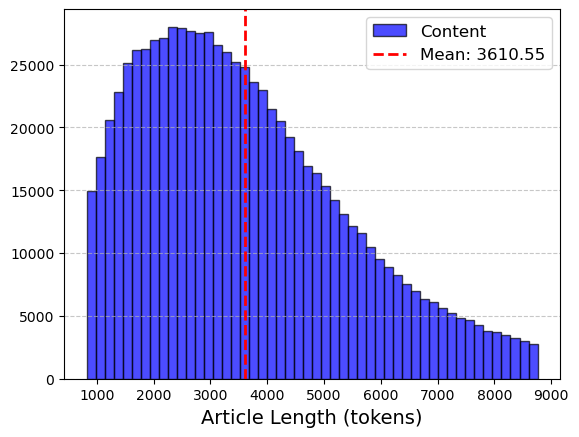

In [9]:
pd.DataFrame(news_data["Content"].str.len()).plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Content"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Content"].str.len().mean():.2f}',
)
plt.xlabel("Article Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [10]:
lengths_summary = news_data["Summary"].str.len()
lengths_summary.describe()

count    783457.000000
mean        288.041624
std         226.311050
min           1.000000
25%         154.000000
50%         244.000000
75%         328.000000
max        8541.000000
Name: Summary, dtype: float64

In [11]:
news_data = news_data[
    (lengths_summary >= lengths_summary.quantile(0.05))
    & (lengths_summary <= lengths_summary.quantile(0.95))
]

In [12]:
news_data["Summary"].str.len().describe()

count    705951.000000
mean        255.337233
std         104.177187
min         103.000000
25%         168.000000
50%         244.000000
75%         317.000000
max         597.000000
Name: Summary, dtype: float64

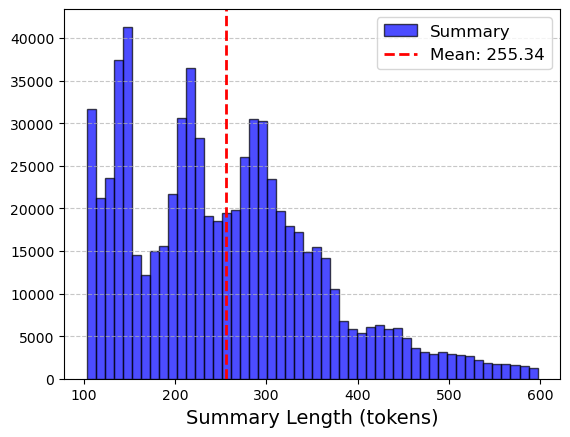

In [13]:
news_data["Summary"].str.len().plot(
    kind="hist", bins=50, edgecolor="black", alpha=0.7, color="blue"
)
plt.axvline(
    news_data["Summary"].str.len().mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Mean: {news_data["Summary"].str.len().mean():.2f}',
)
plt.xlabel("Summary Length (tokens)", fontsize=14)
plt.ylabel("")
plt.legend(fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
news_data["Content"] = news_data["Content"].apply(preprocess_article)
news_data["Summary"] = news_data["Summary"].apply(preprocess_summary)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenized_articles = news_data["Content"].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True) if type(x) is str else []
)
tokenized_summaries = news_data["Summary"].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True) if type(x) is str else []
)

In [ ]:
input_ids = []
max_seq_length = 512
max_sum_length = 512
summary_ids = []

for tokens1, tokens2 in zip(tokenized_articles, tokenized_summaries):
    if len(tokens1) == 0:
        continue
    if len(tokens1) > max_seq_length:
        tokens1 = tokens1[:max_seq_length]
    else:
        tokens1 = tokens1 + [0] * (max_seq_length - len(tokens1))

    if len(tokens2) == 0:
        continue
    if len(tokens2) > max_sum_length:
        tokens2 = [0] + tokens2[:max_sum_length]
    else:
        tokens2 = [0] + tokens2 + [0] * (max_sum_length - len(tokens2))
    input_ids.append(tokens1)
    summary_ids.append(tokens2)

In [ ]:
input_ids = torch.tensor(input_ids, dtype=torch.long)
summary_ids = torch.tensor(summary_ids, dtype=torch.long)

# **RNN**

# **Transformer**

In [ ]:
batch_size = 10
dataset = TensorDataset(input_ids, summary_ids)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model_transformer = Transformer(
    pad_idx=0,
    voc_size=tokenizer.vocab_size,
    hidden_size=128,
    n_head=8,
    max_len=max_seq_length,
    dec_max_len=max_sum_length,
    ffn_hidden=128,
    n_layers=3,
)

In [ ]:
num_epochs = 50
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for step, batch in enumerate(dataloader):
        input_batch, summary_batch = batch
        input_batch = input_batch.to(device)
        summary_batch = summary_batch.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_batch, summary_batch[:, :-1])
        summary_batch = summary_batch[:, 1:]
        # Compute loss
        loss = loss_fn(
            outputs.reshape(-1, outputs.shape[-1]), summary_batch.reshape(-1)
        )
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        if step % 1000 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))

    # Calculate average loss for the epoch
    avg_loss = total_loss / len(dataloader)

    # Print the average loss
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

# **LLM Llama 3.2**

In [ ]:
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
import yaml

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

hf_token = config["huggingface"]["token"]
login("hf_token")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")